# Imports

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.3 MB/s eta 0:00:00


In [ ]:
pip install optuna_integration catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.0 MB/s eta 0:00:00


In [ ]:
from google.colab import files
upload_files = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


In [ ]:
from google.colab import files
upload_files = files.upload()

Saving original.csv to original.csv
Saving ReduceMemory.py to ReduceMemory.py


In [ ]:
import numpy as np
import pandas as pd
pd.pandas.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

# Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

# Models
from lightgbm import LGBMClassifier
from lightgbm import early_stopping
from lightgbm import log_evaluation
from xgboost import XGBClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
import catboost as cat

# scikit learn tools
from scipy.stats import boxcox
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold, train_test_split
from sklearn.metrics import log_loss, accuracy_score, matthews_corrcoef, classification_report

# Optuna
import optuna
from optuna.integration import LightGBMPruningCallback, XGBoostPruningCallback, CatBoostPruningCallback
from optuna.visualization import (plot_intermediate_values, plot_param_importances,
                                  plot_parallel_coordinate, plot_optimization_history)

# Import python files
from ReduceMemory import import_data


# Data Analysation

In [ ]:
# import the datasets through the reduce memory usage python file
# Credit: https://www.kaggle.com/code/gemartin/load-data-reduce-memory-usage
train = import_data('train.csv')
test = import_data('test.csv')
original = import_data('original.csv')

test_id = test['id']

train_copy = train.copy()
test_copy = test.copy()

train_copy.drop(columns=["id"], inplace=True)
test_copy.drop(columns=['id'], inplace=True)

original_columns = original.columns
original_copy = original.copy()

Memory usage of dataframe is 523.17 MB
Memory usage after optimization is: 83.26 MB
Decreased by 84.1%
Memory usage of dataframe is 332.93 MB
Memory usage after optimization is: 53.53 MB
Decreased by 83.9%
Memory usage of dataframe is 9.78 MB
Memory usage after optimization is: 1.40 MB
Decreased by 85.7%


### Missing Data

In [ ]:
table = PrettyTable()
table.field_names = ['Feature', 'Data Type', 'Train Missing %', 'Test Missing %', 'Original MIssing %']
for col in train_copy.columns:
  data_type = str(train_copy[col].dtype)
  non_null_count_train = np.round(100-train_copy[col].count()/train_copy.shape[0]*100, 1)
  if col != 'class':
    non_null_count_test = np.round(100-test_copy[col].count()/test_copy.shape[0]*100, 1)
  else:
    non_null_count_test = 'NAN'
  non_null_count_orig = np.round(100-original_copy[col].count()/original_copy.shape[0]*100, 1)
  table.add_row([col, data_type, non_null_count_train, non_null_count_test, non_null_count_orig])

print(table)

+----------------------+-----------+-----------------+----------------+--------------------+
|       Feature        | Data Type | Train Missing % | Test Missing % | Original MIssing % |
+----------------------+-----------+-----------------+----------------+--------------------+
|        class         |  category |       0.0       |      NAN       |        0.0         |
|     cap-diameter     |  float16  |       0.0       |      0.0       |        0.0         |
|      cap-shape       |  category |       0.0       |      0.0       |        0.0         |
|     cap-surface      |  category |       21.5      |      21.5      |        23.1        |
|      cap-color       |  category |       0.0       |      0.0       |        0.0         |
| does-bruise-or-bleed |  category |       0.0       |      0.0       |        0.0         |
|   gill-attachment    |  category |       16.8      |      16.8      |        16.2        |
|     gill-spacing     |  category |       40.4      |      40.4      

### Target Distribution

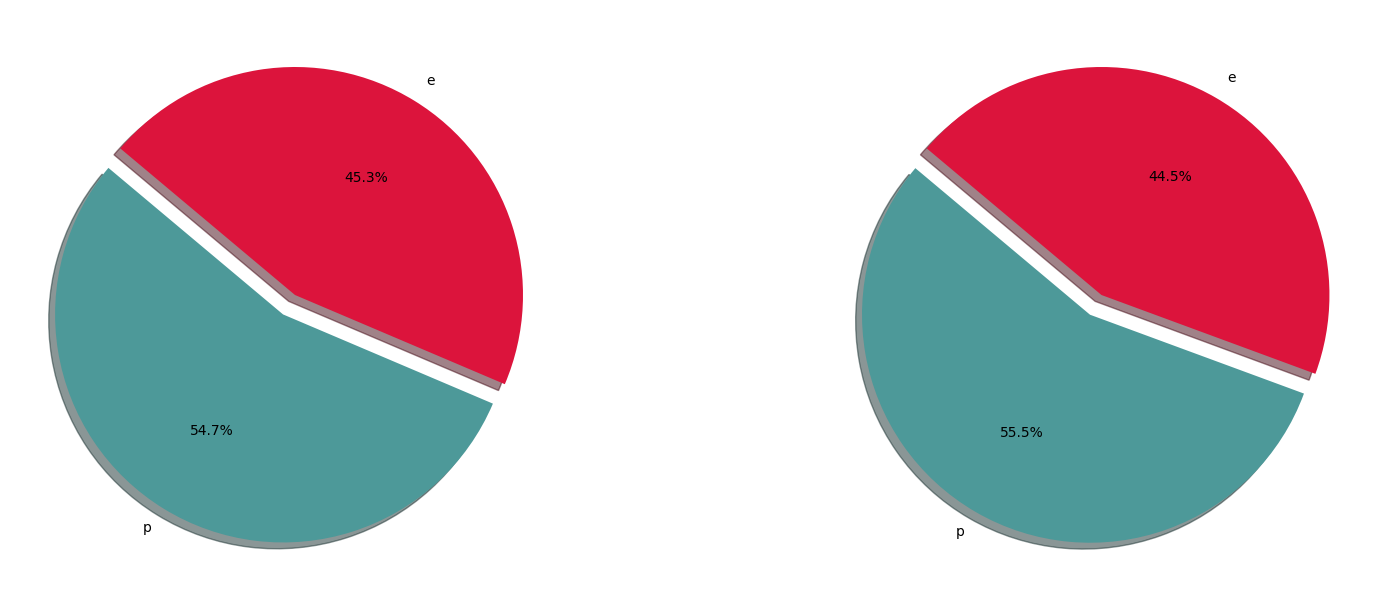

In [ ]:
def plot_pie_chart(df, title, ax):
  data_counts = df['class'].value_counts()
  labels = data_counts.index
  sizes = data_counts.values
  colors = [ (0.3, 0.6, 0.6), 'crimson']
  explode = (0.1, 0)
  ax.pie(sizes, explode=explode, labels=labels, colors=colors,
         autopct='%1.1f%%', shadow=True, startangle=140)

fig, axes = plt.subplots(1, 2, figsize=(18,6))

plot_pie_chart(train_copy, 'Train Class Status Distribution', axes[0])
plot_pie_chart(original, 'Original class status Distribution', axes[1])

plt.tight_layout()
plt.show()

### Numerical Feature Distribution

The dataset is messy. We have 74 unique categories in cap-shape although in the original dataset there is only 6 categories. This is the case with a few other categories. We will remove these annomialises.

(moving forward after this we will make a category bin for the noise)

Note to self: Best for the competition rather than removing them put the non arithmetic categories in a new noise category. If we do decide to use the extra 1 million samples for training too, we will do the same thing.

In [ ]:
table = PrettyTable()
table.field_names = ['Feature', 'No. Categories']

cont_cols = ['cap-diameter', 'stem-height', 'stem-width']
cat_cols = [col for col in original_columns if col not in cont_cols]
for feature in original_columns:
  if feature in cat_cols:
    categories = sorted(list(set(original[feature].dropna())))
    dtype = pd.CategoricalDtype(categories=categories, ordered=False)
    table.add_row([feature, len(dtype.categories)])
    train.loc[~train[feature].isin(categories), feature] = np.nan
    if feature != 'class':
      test.loc[~test[feature].isin(categories), feature] = np.nan
  else:
    dtype = np.float32

  train[feature] = train[feature].astype(dtype)
  original[feature] = original[feature].astype(dtype)
  if feature != 'class':
    test[feature] = test[feature].astype(dtype)

print(table)

del train_copy, test_copy

+----------------------+----------------+
|       Feature        | No. Categories |
+----------------------+----------------+
|        class         |       2        |
|      cap-shape       |       7        |
|     cap-surface      |       11       |
|      cap-color       |       12       |
| does-bruise-or-bleed |       2        |
|   gill-attachment    |       7        |
|     gill-spacing     |       3        |
|      gill-color      |       12       |
|      stem-root       |       5        |
|     stem-surface     |       8        |
|      stem-color      |       13       |
|      veil-type       |       1        |
|      veil-color      |       6        |
|       has-ring       |       2        |
|      ring-type       |       8        |
|  spore-print-color   |       7        |
|       habitat        |       8        |
|        season        |       4        |
+----------------------+----------------+


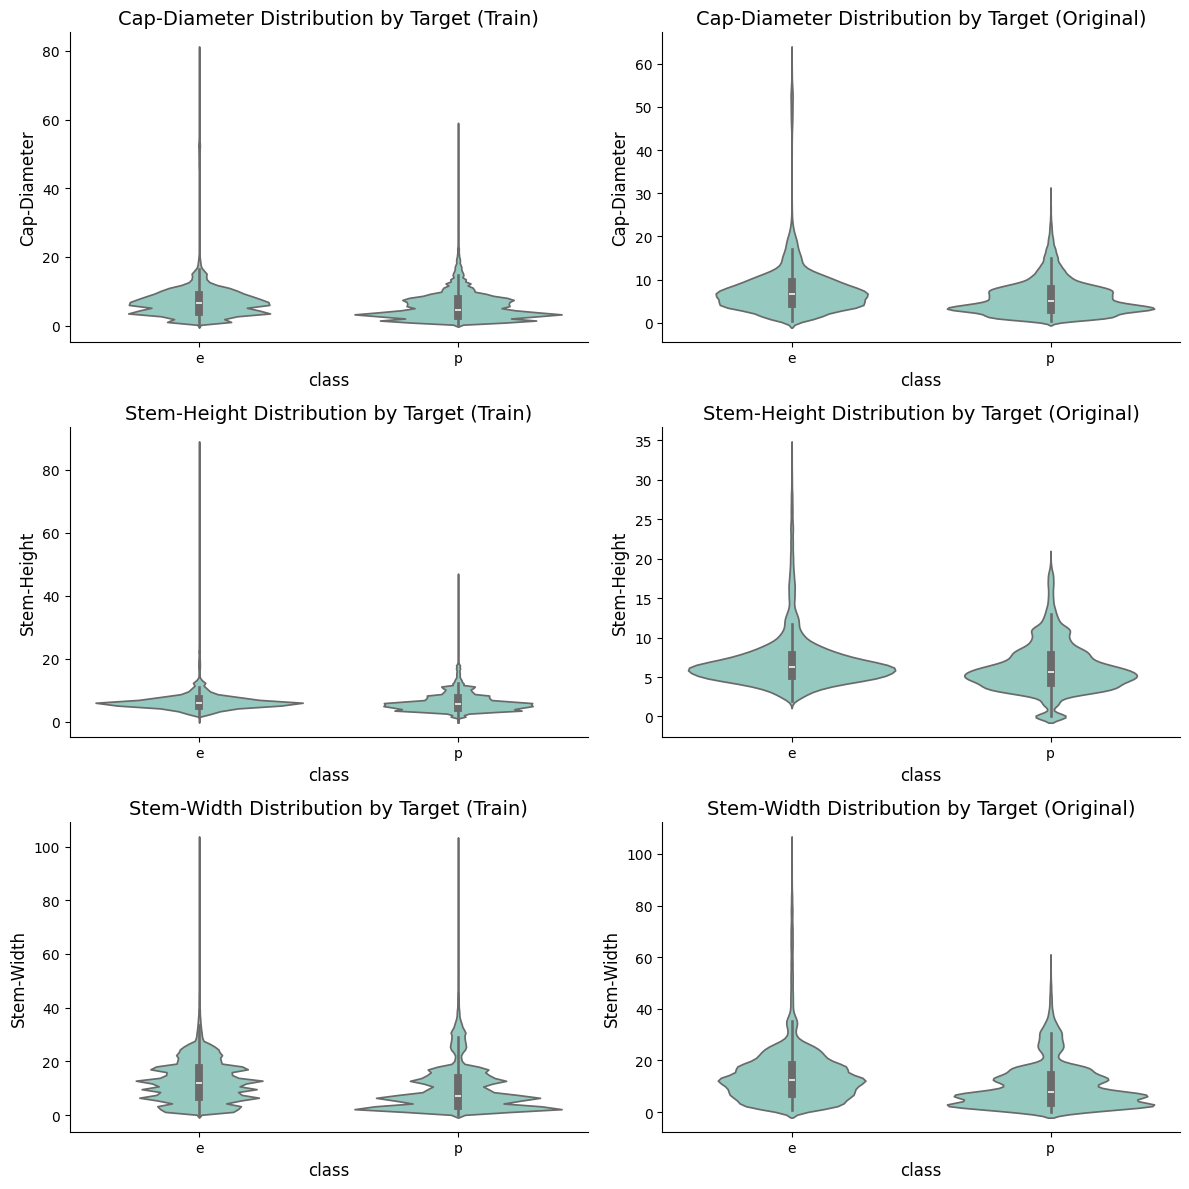

In [ ]:
# Numerical Distribution. Violin plots
train_copy = train.copy()
test_copy = test.copy()

train_copy.drop(columns=["id"], inplace=True)
test_copy.drop(columns=['id'], inplace=True)

n_rows = len(cont_cols)
fig, axs = plt.subplots(n_rows, 2, figsize=(12, 4 * n_rows))
sns.set_palette("Set3")
for i, col in enumerate(cont_cols):
    sns.violinplot(x='class', y=col, data=train_copy, ax=axs[i, 0])
    axs[i, 0].set_title(f'{col.title()} Distribution by Target (Train)', fontsize=14)
    axs[i, 0].set_xlabel('class', fontsize=12)
    axs[i, 0].set_ylabel(col.title(), fontsize=12)
    sns.despine()

    sns.violinplot(x='class', y=col, data=original, ax=axs[i, 1])
    axs[i, 1].set_title(f'{col.title()} Distribution by Target (Original)', fontsize=14)
    axs[i, 1].set_xlabel('class', fontsize=12)
    axs[i, 1].set_ylabel(col.title(), fontsize=12)
    sns.despine()

fig.tight_layout()
plt.show()

<Figure size 1800x1000 with 0 Axes>

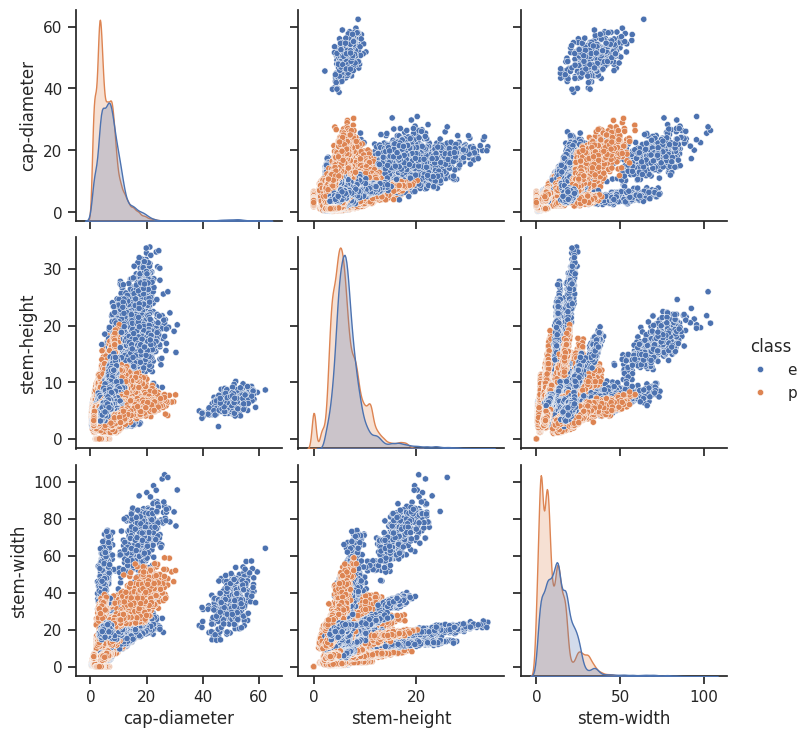

In [ ]:
# Numerical Pair Plots
sns.set(font_scale=1)
plt.figure(figsize=(18,10))
sns.set(style='ticks', color_codes=True)
sns.pairplot(data=original, vars=cont_cols, diag_kind='kde',
             kind='scatter', palette='deep', plot_kws={'s':20},
             hue='class')
plt.show()

### Categorical Distribution

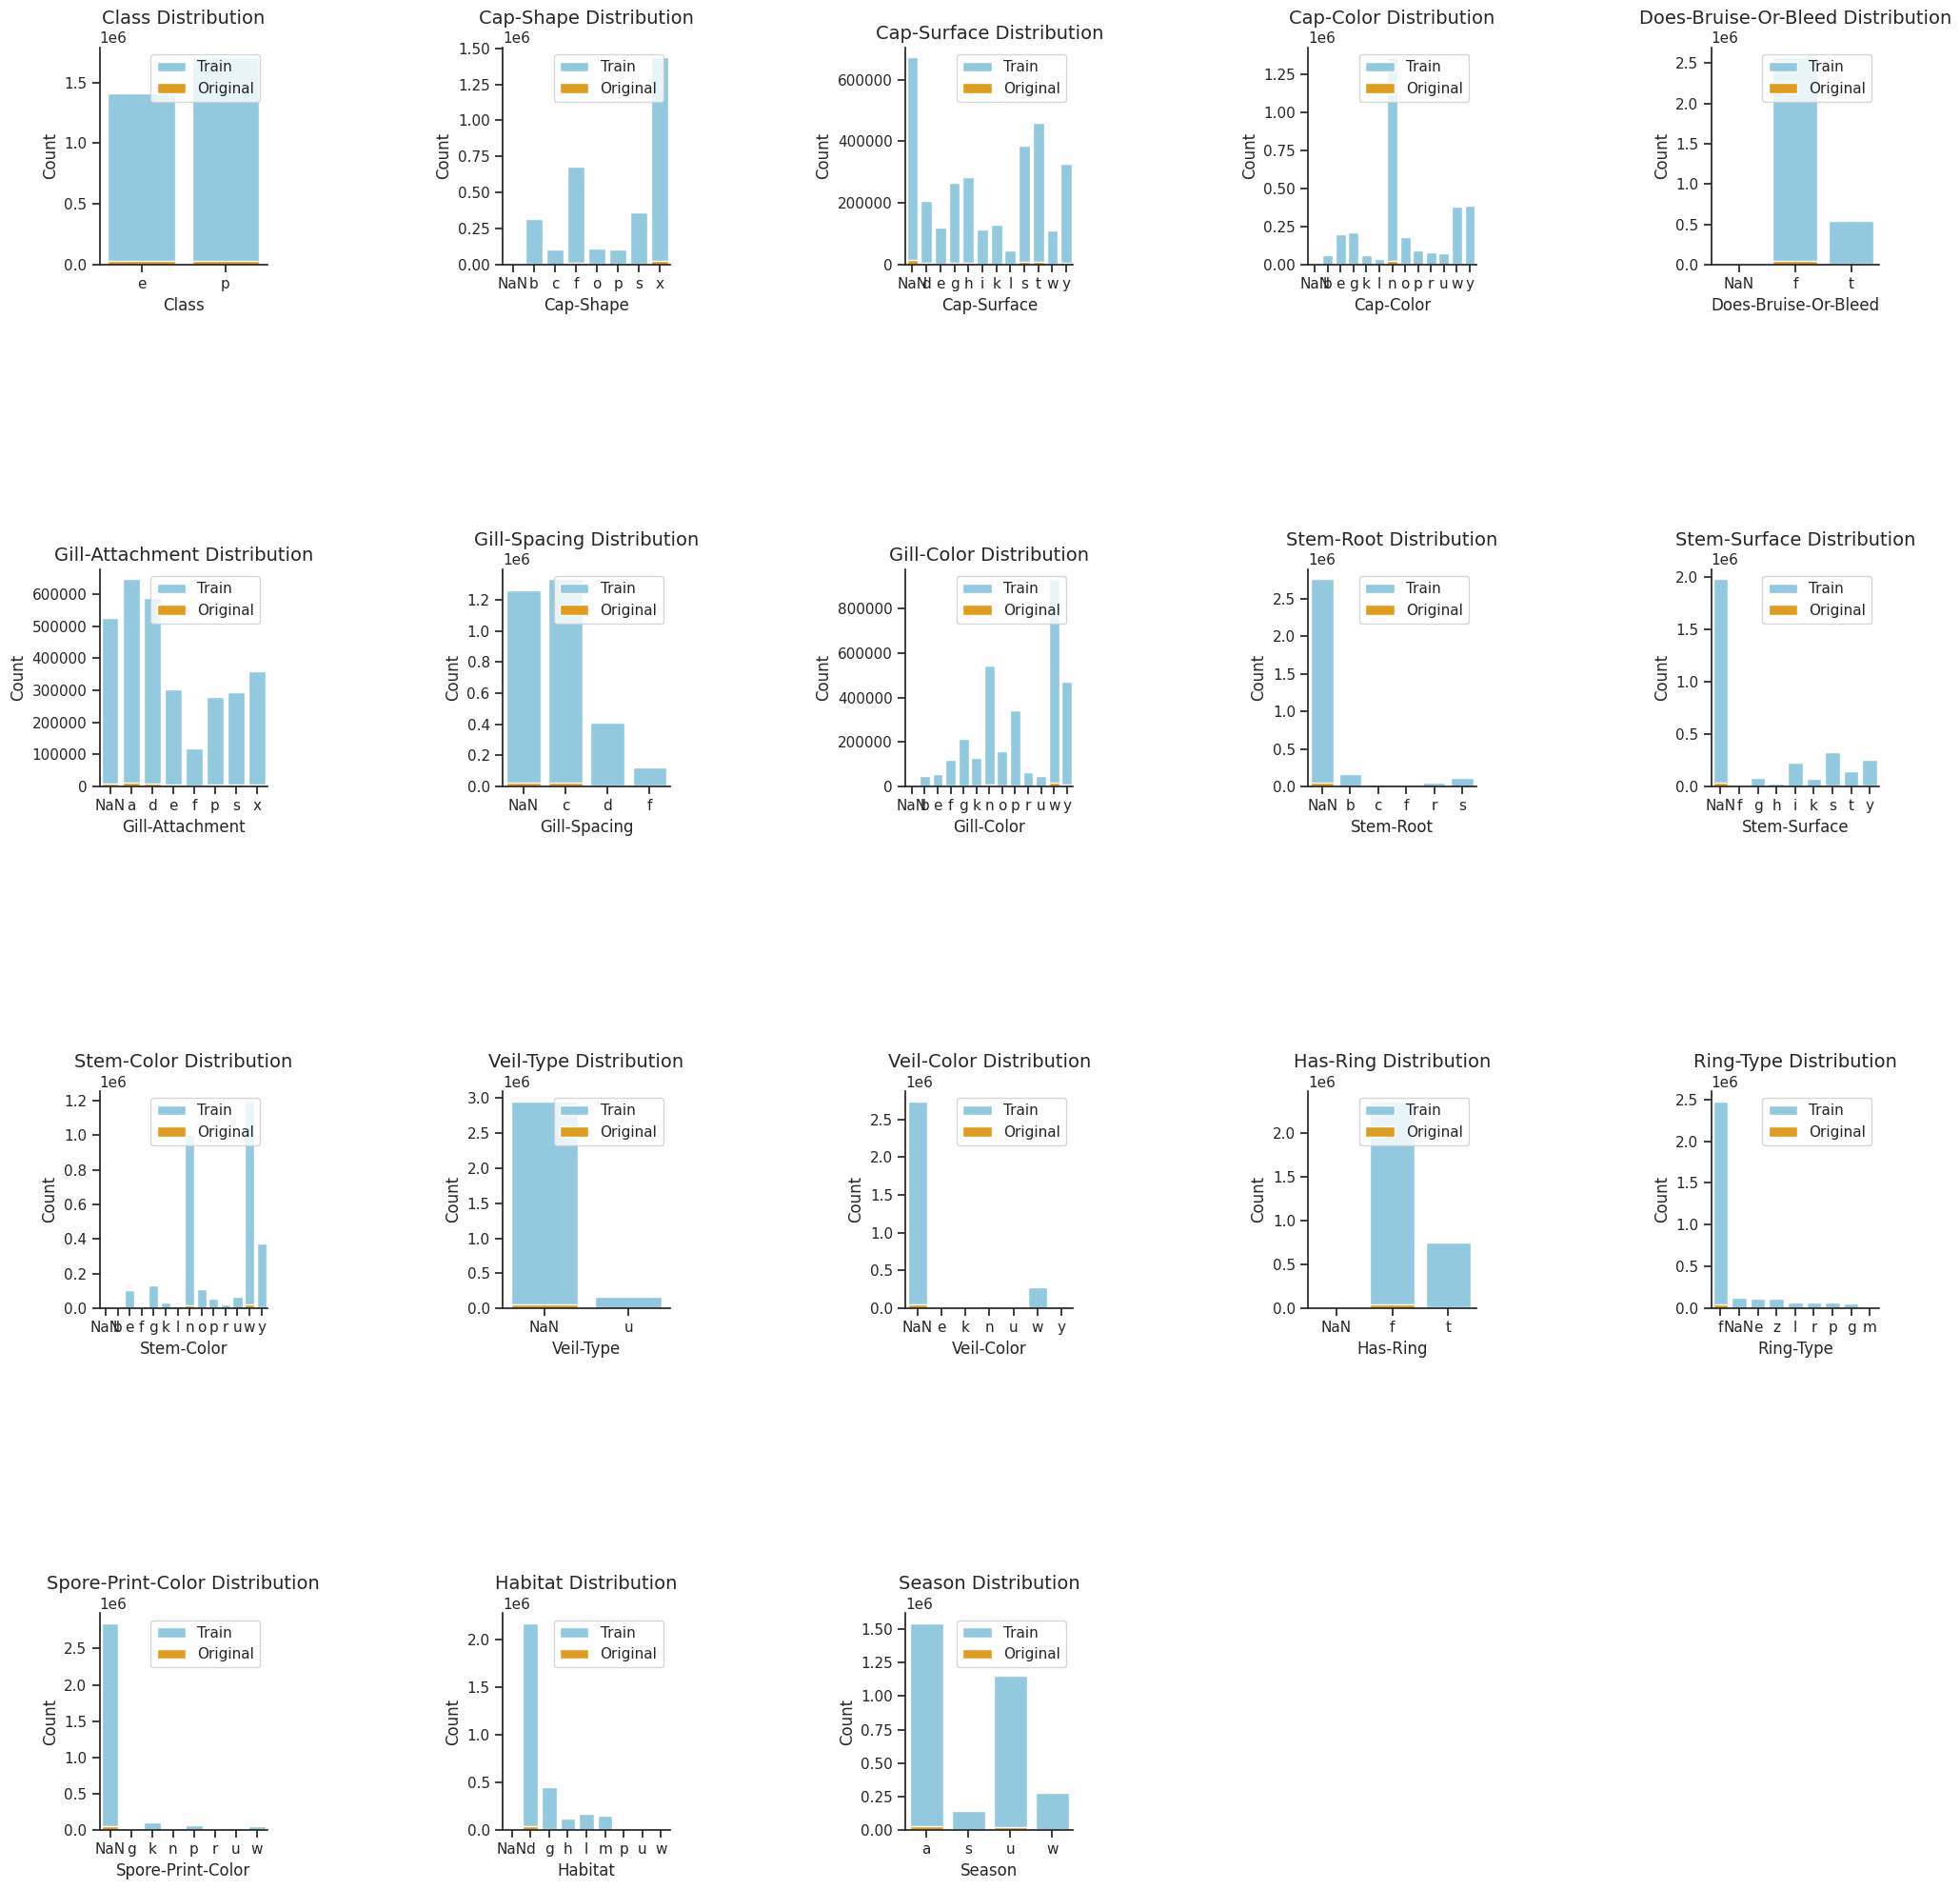

In [ ]:
train_copy['dataset'] = 'Train'
original_copy['dataset'] = 'Original'

def count_with_nan(df, col):
    counts = df[col].value_counts(dropna=False)
    counts.index = counts.index.fillna('NaN')
    return counts

data_combined = pd.concat([train_copy, original_copy], ignore_index=True)

fig, axs = plt.subplots(4, 5, figsize=(20,20))
axs = axs.flatten()
sns.set_palette("Set2")
for i, col in enumerate(cat_cols):

    train_counts = count_with_nan(train_copy, col)
    original_counts = count_with_nan(original_copy, col)

    combined_counts = pd.DataFrame({
        'Train': train_counts,
        'Original': original_counts}).fillna(0)

    combined_counts.reset_index(inplace=True)
    combined_counts.rename(columns={'index':col}, inplace=True)

    sns.barplot(x=col, y='Train', data=combined_counts, ax=axs[i], color='skyblue', label='Train')
    sns.barplot(x=col, y='Original', data=combined_counts, ax=axs[i], color='orange', label='Original')#, bottom=combined_counts['Train'])

    #sns.countplot(x=col, hue='dataset', data=data_combined, ax=axs[i], order=data_combined[col].value_counts().index)
    axs[i].set_title(f'{col.title()} Distribution', fontsize=14)
    axs[i].set_xlabel(col.title(), fontsize=12)
    axs[i].set_ylabel('Count', fontsize=12)
    axs[i].legend(loc='upper right')
    sns.despine()

# Remove the 3 empty subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.subplots_adjust(wspace=1.4, hspace=1.4)
plt.show()

del data_combined, axs, fig, train_copy, original_copy

# Feature Engineering

Note: Not using my feature_engineering_1-0-1.py code here since I haven't fine tuned it. As a result, this is my temporary feature engineering code which I used in Model_1-0-3.py

In [ ]:
for col in cat_cols:
    if col == 'class':
        continue
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col].astype(str))
    test[col] = le.fit_transform(test[col].astype(str))

X = train.drop(columns=['class', 'id'])
label_encoder = LabelEncoder()
X_test = test_copy
y = train['class']
y = label_encoder.fit_transform(train['class'])

### Numerical Engineering

We transform the data using a Box-Cox transformation and also remove outliers. Transformations are helpful when the data is highly skewed and the variance increases with the mean, here the Box-Cox is a family of the power transformations. Additionally, the transformation is used to help normalise the data which will help with the models we will be applying. After tansforming the data we will remove the outliers for the features. These outliers (seen in the violin plots) when removed will reduce the impact of extreme values without losing valuable data, and stabilise the dataset. Then scale the data.

To maintain consistency throughout, this process will be applied to both train and test datasets.

In [ ]:
def RobustScaleData(df, cont_cols):
    sc = RobustScaler()

    for col in cont_cols:
        df[col] = sc.fit_transform(df[[col]])

    return df

def StandardScaleData(df, cont_cols):
    sc = StandardScaler()

    for col in cont_cols:
        df[col] = sc.fit_transform(df[[col]])

    return df

def outliers(df, cont_cols):
    '''
    Same as School Math calculation to find the outliers
    '''

    for col in cont_cols:
        Q3 = df[col].quantile(0.75)
        Q1 = df[col].quantile(0.25)
        InterQuantileRange = Q3 - Q1
        lower = Q1 - 1.5 * InterQuantileRange
        upper = Q3 + 1.5 * InterQuantileRange

        df[col] = df[col].clip(lower=lower, upper=upper)

    return df

def BoxCoxTransformation(df, cont_cols, threshold):
    '''

    Taking The Box-Cox Transformation from the transformation definition in Feature_Engineering_1-0-1.py
    My mistake before was applying this to the dataset after the robust scaling which caused math errors

    The next try is to do multiple transformation and test which is best
    '''
    #df = pd.concat([train, test], axis="rows")

    dic = {}
    epsilon = 1e-4

    for col in cont_cols:

        if df[col].min() <= 0:
            df[col] = df[col] - df[col].min() + epsilon

        if df[col].skew() > threshold:
            df[col], fit_lambda = boxcox(df[col])
            # Alternatively
            #transformer = PowerTransformer(method='box-cox')
            #scaled_data = transformer.fit_transform(combined_data + epsilon)
            dic[col] = fit_lambda

    return df, dic



def numerical_engineering(df, threshold: float = 1.0):
    '''
    The numerical engineering is taken from Feature_Engineering_1-0-1.py but is approached in the
    reverse way. i.e. BoxCox first then removing Outliers then Scaling

    Outliers is a new method which we are trying to reduce overfitting

    Before doing this we will remove the non-finite values in the continuous columns
    '''
    #cont_cols = df.select_dtypes(include=['number']).columns
    cont_cols = ['cap-diameter', 'stem-height', 'stem-width']
    for col in cont_cols:
        #if not np.all(np.isfinite(train[col])):
        if df[col].isnull().any():
            median = df[col].median()
            #df[col] = df[col].replace([np.inf, -np.inf], np.nan, inplace=True)
            df[col] = df[col].fillna(median)


    # 1. BoxCox removing the skewness
    df, boxcox_lambdas = BoxCoxTransformation(df, cont_cols, threshold=threshold)
    # 2. Removing outliers
    df = outliers(df, cont_cols)
    # 3. Scaling
    df = StandardScaleData(df, cont_cols)
    #RobustScaleData(df, cont_cols)

    return df

X = numerical_engineering(X)
X_test = numerical_engineering(X_test)

### Categorical Engineering

Using an ordinal encoder to encode the categorical features. The ordinal encoder is handy to maintain the ranking of the categories, which will allow the model to leverage the hierarchy of the datasets. This encoder is particularly handy for gradient boosting models since it allows the model to make better splits of the data based on ordinal relationships betweem the categories.

In [ ]:
cat_cols = [col for col in X.columns if col != 'class']

ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

X[cat_cols] = ordinal_encoder.fit_transform(X[cat_cols].astype(str))
X_test[cat_cols] = ordinal_encoder.fit_transform(X_test[cat_cols].astype(str))

# Optuna

In [ ]:
global RANDOM_STATE
RANDOM_STATE = 81 # Oscar Piastri

As of right now the training and optunacode will only be for XGBoost model instead of a collection of XGB, LGBM, CAT models. This will come later.

In [ ]:
def objective(trial):
    params = {
        #'boosting_type':'gbdt',
        #'reg_alpha': trial.suggest_float('reg_alpha', 40,180),
        'n_estimators': trial.suggest_int('n_estimators', 100, 10000),
        'max_depth': trial.suggest_int('max_depth', 6, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.9),
        'gamma': trial.suggest_float('gamma', 1e-10, 2.0, log=True),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 10.0, log=True),
        'subsample' : trial.suggest_float('subsample', 0.5, 1),
        'alpha' : trial.suggest_float('alpha', 1e-10, 10, log=True),
        'n_jobs': -1,
        'early_stopping_rounds': 50,
        'random_state': RANDOM_STATE#,
        #'device' : 'gpu'
        }

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify= y, random_state=RANDOM_STATE)

    model = XGBClassifier(**params, eval_metric='logloss', verbosity=0)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    y_pred = model.predict(X_val)

    ### Evaluate the model
    mcc = matthews_corrcoef(y_val, y_pred)
    trial.set_user_attr("mcc", mcc)
    return mcc


def callback_mcc(study, trial):
    mcc = trial.user_attrs['mcc']
    print(f'Trial {trial.number}: MCC = {mcc}')

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials = 50, callbacks=[callback_mcc], n_jobs=-1)

print('='*50)
print('Best Trial:', study.best_trial)
print('Best Score:', study.best_value)
print('='*50)
print('Best Params:', study.best_params)

best_params = study.best_params

plot_optimization_history(study)
plot_parallel_coordinate(study)
plot_param_importances(study)

# Training

The main metric for this competition is Matthews Correlation Coefficient (MCC). We will be doing a 10 stratified fold cross validation and create a confidence interval on the results of the 10 folds to determine where our result will lie.

In [ ]:
def cross_validate_score(model, X, y, cv=None,
                         test_data: pd.DataFrame = None,
                         include_original: bool = True,
                         original_data: pd.DataFrame = None,
                         n_jobs = -1,
                         verbose=True):
    if cv is None:
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
    if test_data is None:
        raise ValueError("test_data must  be provided")

    oof_val_preds = np.zeros(X.shape[0])
    oof_test_preds = np.zeros(test_data.shape[0])
    train_scores, val_scores = [], []

    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_train = X.iloc[train_idx]
        y_train = y[train_idx]
        X_val = X.iloc[val_idx]
        y_val = y[val_idx]

        model_cloned = clone(model)

        if isinstance(model_cloned, XGBClassifier):
            eval_set = [(X_val, y_val)]
            model_cloned.fit(X_train, y_train, eval_set=eval_set, verbose=False)
            best_iteration = model_cloned.best_iteration
            train_pred = model_cloned.predict(X_train, iteration_range=(0, best_iteration))
            val_pred = model_cloned.predict(X_val, iteration_range=(0, best_iteration))
            test_pred = model_cloned.predict(test_data.drop(columns=['id']), iteration_range=(0, best_iteration))

            train_mcc = matthews_corrcoef(y_train, train_pred)
            val_mcc = matthews_corrcoef(y_val, val_pred)
            train_scores.append(train_mcc)
            val_scores.append(val_mcc)

        else:
            raise ValueError('Model type not supported for early stopping')

        oof_val_preds[val_idx] = val_pred

        print(f'Fold {fold}: {val_scores[-1]:.5f}')

        oof_test_preds += test_pred / cv.get_n_splits()

    print(f'Val Score: {np.mean(val_scores):.7f} ± {np.std(val_scores):.7f} | Train Score: {np.mean(train_scores):.7f} ± {np.std(train_scores):.7f}')

    return val_scores, oof_val_preds, oof_test_preds

cv_summary, oof_predictions, oof_test_preds = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

# Optuna best params
xgb_params = {'n_estimators': 1333,
              'max_depth': 15,
              'learning_rate': 0.02324307767838865,
              'colsample_bytree': 0.5735769796636672,
              'gamma': 6.187514110554392e-10,
              'min_child_weight': 2.4743403940523843,
              'subsample': 0.5819269226270195,
              'alpha': 2.6436480556279035e-09,
              'device': 'gpu'} # tuned earlier params using the exact same code above

# xgb_params = study.best_params

xgb_tuned = XGBClassifier(**xgb_params, eval_metric='logloss',
                          early_stopping_rounds=50, random_state=RANDOM_STATE,
                          verbosity=0)

cv_summary['xgb'], oof_predictions['xgb'], oof_test_preds['xgb'] = cross_validate_score(xgb_tuned,
                                                                                        X=X, y=y,
                                                                                        test_data=X_test,
                                                                                        include_original=False)



### Submission

In [ ]:
oof_test_preds_int = (oof_test_preds > 0.5).astype(int)
original_labels = label_encoder.inverse_transform(oof_test_preds_int.astype(int)['xgb'])

submission = pd.DataFrame()
submission['id'] = test_id
submission['class'] = original_labels
print(submission.head())

#submission.to_csv('submission.csv', index=False)